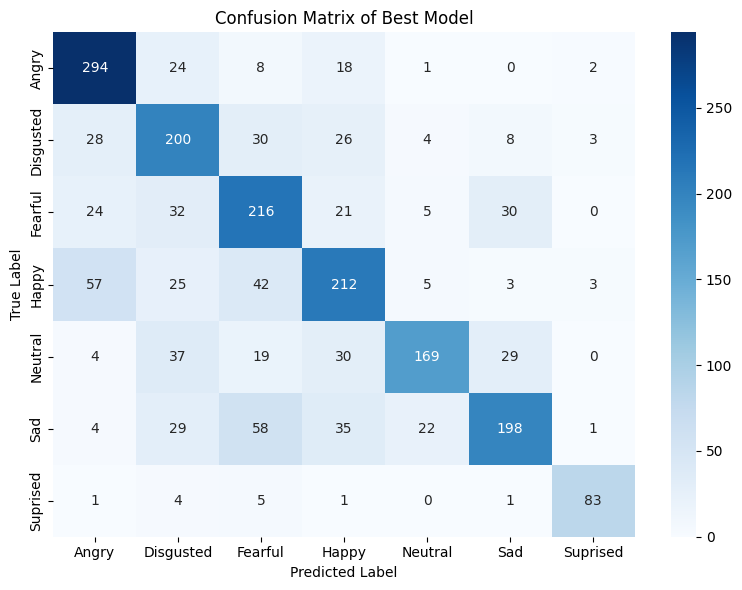

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import librosa
import numpy as np
from sklearn.model_selection import train_test_split
from IPython.display import clear_output
import matplotlib.pyplot as plt

# Emotion labels
labels = ['Angry', 'Disgusted', 'Fearful', 'Happy', 'Neutral', 'Sad', 'Suprised']
label_to_index = {label: i for i, label in enumerate(labels)}

# Dataset class
class AudioEmotionDataset(Dataset):
    def __init__(self, file_paths, sr=22050, max_len=5.0, n_mels=128):
        self.file_paths = file_paths
        self.sr = sr
        self.n_mels = n_mels
        self.max_len = max_len

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        path, label = self.file_paths[idx]
        y, sr = librosa.load(path, sr=self.sr, duration=self.max_len)
        if len(y) < int(self.max_len * sr):
            y = np.pad(y, (0, int(self.max_len * sr) - len(y)))

        mel = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=self.n_mels)
        mel_db = librosa.power_to_db(mel, ref=np.max)
        mel_tensor = torch.tensor(mel_db).unsqueeze(0)  # [1, 128, T]

        return mel_tensor.float(), torch.tensor(label)

# Prepare stratified split file paths
from collections import defaultdict
all_file_paths = []
dataset_path = "elec378 sp25 dataset"
for label in labels:
    folder = os.path.join(dataset_path, label)
    if not os.path.isdir(folder):
        continue
    for file in os.listdir(folder):
        if file.endswith(".wav"):
            all_file_paths.append((os.path.join(folder, file), label_to_index[label]))

by_label = defaultdict(list)
for path, label in all_file_paths:
    by_label[label].append((path, label))

train_data, val_data = [], []
for label, items in by_label.items():
    train_split, val_split = train_test_split(items, test_size=0.2, random_state=42)
    train_data.extend(train_split)
    val_data.extend(val_split)

train_dataset = AudioEmotionDataset(train_data)
val_dataset = AudioEmotionDataset(val_data)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)

# Dynamic CNN
class AudioCNN(nn.Module):
    def __init__(self, num_classes=7, filters=[16, 32, 64], fc_dim=128, dropout=0.3):
        super(AudioCNN, self).__init__()
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(1, filters[0], kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(filters[0]),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2))
        )
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(filters[0], filters[1], kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(filters[1]),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2))
        )
        self.conv_block3 = nn.Sequential(
            nn.Conv2d(filters[1], filters[2], kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(filters[2]),
            nn.ReLU(),
            nn.AdaptiveMaxPool2d((4, 4))
        )
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(filters[2] * 4 * 4, fc_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(fc_dim, num_classes)
        )

    def forward(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.conv_block3(x)
        x = self.fc(x)
        return x

# Train once function

def train_one(model, train_loader, val_loader, epochs=5, lr=0.001):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    for epoch in range(1, epochs + 1):
        model.train()
        total_loss = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

        print(f"Epoch {epoch}/{epochs} - Train Loss: {total_loss:.4f} | Val Loss: {val_loss:.4f}")

    return total_loss, val_loss, model.state_dict()

# Architecture search
architectures = [
     # Around best: 256, 0.2  
    {"filters": [16, 32, 64], "fc_dim": 1098, "dropout": 0.25},
 
     
]

results = []
#for arch in architectures:
   # print("Testing architecture:", arch)
    #model = AudioCNN(num_classes=7, **arch)
    #train_loss, val_loss, weights = train_one(model, train_loader, val_loader, epochs=2)
   # results.append((arch, val_loss, weights))

# Choose best architecture
#best_arch, best_val_loss, best_weights = min(results, key=lambda x: x[1])
#print("Best architecture:", best_arch, "with val loss:", best_val_loss)

# Retrain best architecture with early stopping

def train_with_early_stopping(model, train_loader, val_loader, max_epochs=20, lr=0.001):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    best_val_loss = float('inf')
    best_model = None

    train_losses = []
    val_losses = []

    for epoch in range(1, max_epochs + 1):
        model.train()
        total_loss = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

        train_losses.append(total_loss / 4)  # Scale down training loss
        val_losses.append(val_loss)

        clear_output(wait=True)
        print(f"Epoch {epoch}/{max_epochs} - Train Loss: {total_loss:.4f} | Val Loss: {val_loss:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model = model.state_dict()
        else:
            print("Validation loss increased. Stopping early and keeping best model.")
            print(f"Previous best: {best_val_loss:.4f} | Current val: {val_loss:.4f}")
            break

    if best_model:
        torch.save(best_model, "audio_emotion_model.pth")
        print("✅ Best model saved as audio_emotion_model.pth")

    # Plot the losses
    plt.figure(figsize=(8, 5))
    plt.plot(train_losses, label='Training Loss (scaled)')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (scaled)')
    plt.title('Training vs Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig("training_vs_validation_loss.png")
    plt.show()

# Final run
model = AudioCNN(num_classes=7, filters=[16, 32, 64], fc_dim=1098, dropout=0.25)

# 
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import torch

# Load and evaluate saved model
model = AudioCNN(num_classes=7, filters=[16, 32, 64], fc_dim=1098, dropout=0.25)
model.load_state_dict(torch.load("643.pth", map_location=torch.device("cpu")))
model.eval()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

true_labels = []
predicted_labels = []

with torch.no_grad():
    for inputs, labels in val_loader:  # using validation set as test set
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        preds = torch.argmax(outputs, dim=1)
        predicted_labels.extend(preds.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

# Confusion matrix as percentages (normalize='true')
cm = confusion_matrix(true_labels, predicted_labels, normalize='true') * 100
labels_display = ['Angry', 'Disgusted', 'Fearful', 'Happy', 'Neutral', 'Sad', 'Suprised']

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='.1f', cmap='Blues',
            xticklabels=labels_display, yticklabels=labels_display)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Row-Normalized %)')
plt.tight_layout()
plt.savefig("confusion_matrix_percent.png")
plt.show()

In [ ]:
model = AudioCNN(num_classes=7, filters=[16, 32, 64], fc_dim=1098, dropout=0.25)

# 
train_with_early_stopping(model, train_loader, val_loader, max_epochs=20)

KeyboardInterrupt: 

In [ ]:
import os
import torch
import librosa
import numpy as np
import pandas as pd
from torch.utils.data import Dataset, DataLoader
# Emotion labels
labels = ['Angry', 'Disgusted', 'Fearful', 'Happy', 'Neutral', 'Sad', 'Suprised']
index_to_label = {i: label for i, label in enumerate(labels)}
best_arch = {"filters": [16, 32, 64], "fc_dim": 1098, "dropout": 0.25}  # slightly more
# Load the trained model
model = AudioCNN(num_classes=7, **best_arch)
model.load_state_dict(torch.load("audio_emotion_model.pth", map_location=torch.device('cpu')))
model.eval()


# Test Dataset
class TestAudioDataset(Dataset):
    def __init__(self, test_dir, sr=22050, max_len=5.0, n_mels=128):
        self.file_paths = []
        self.sr = sr
        self.n_mels = n_mels
        self.max_len = max_len

        # Sort files numerically: 1.wav, 2.wav, ..., 10.wav
        for file in sorted(os.listdir(test_dir), key=lambda x: int(os.path.splitext(x)[0])):
            if file.endswith(".wav"):
                self.file_paths.append(os.path.join(test_dir, file))

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        path = self.file_paths[idx]
        y, sr = librosa.load(path, sr=self.sr, duration=self.max_len)
        if len(y) < int(self.max_len * sr):
            y = np.pad(y, (0, int(self.max_len * sr) - len(y)))

        mel = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=self.n_mels)
        mel_db = librosa.power_to_db(mel, ref=np.max)
        mel_tensor = torch.tensor(mel_db).unsqueeze(0).float()  # [1, 128, T]

        filename = os.path.basename(path)
        return mel_tensor, filename


test_path = "elec378 sp25 dataset/Test"  # <-- test path 
test_dataset = TestAudioDataset(test_path)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# Run inference
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

predictions = []

with torch.no_grad():
    for mel_tensor, filename in test_loader:
        mel_tensor = mel_tensor.to(device)
        output = model(mel_tensor)
        predicted_index = torch.argmax(output, dim=1).item()
        predicted_emotion = index_to_label[predicted_index]
        predictions.append((filename[0], predicted_emotion))

# Create CSV
submission_df = pd.DataFrame(predictions, columns=["name", "emotion"])
submission_df.to_csv("submission.csv", index=False)
print(" Saved predictions to submission.csv!")


 Saved predictions to submission.csv
